---

# Lecture 5.1 Single Neuron Logistic Regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RandyRDavila/Data_Science_and_Machine_Learning_Spring_2022/blob/main/Lecture_5/Lecture_5_1.ipynb)

In this notebook we revisit machine learning classification problems. More specifically, we consider the *probabilistic binary classfication problem*. We model this problem as a single neuron model with the *binary cross entropy loss function*. As with single neuron linear regression, we will train our neuron with stochastic gradient descent. 

## Why Probabilistic Neuron Output?
In previous binary classification problems, such as when we applied the perceptron single neuron model, we were assuming that our data was linearly seperable. For example, consider the two figures generated by running the following code. 


---

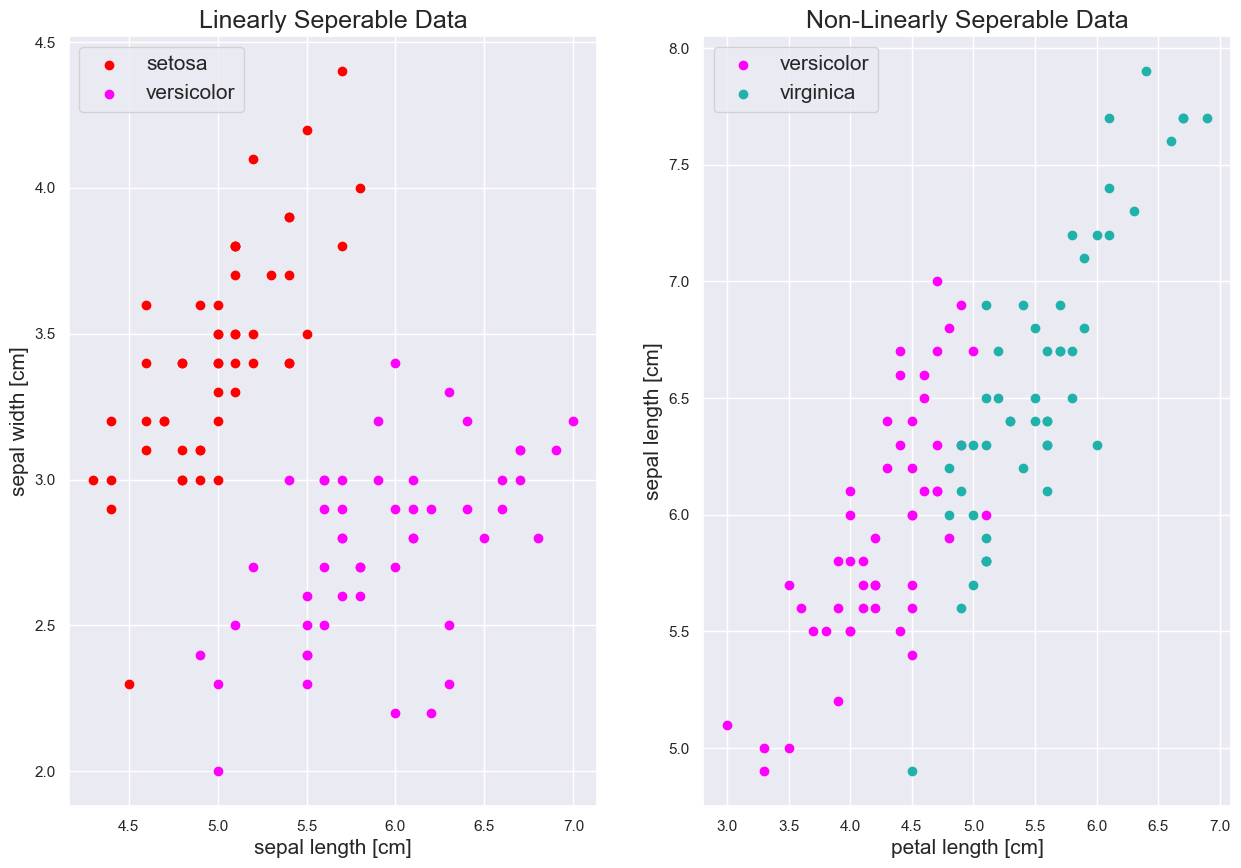

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boudaries
from mlxtend.plotting import plot_decision_regions

# Set the Seaborn theme
sns.set_theme()

# Read the iris dataset into a pandas DataFrame object with seaborn
df = sns.load_dataset("iris")

setosa = df[df.species == "setosa"]
versicolor = df[df.species == "versicolor"]
virginica = df[df.species == "virginica"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.scatter(setosa.sepal_length, 
            setosa.sepal_width, 
            color = "red", 
            label = "setosa")
ax1.scatter(versicolor.sepal_length, 
            versicolor.sepal_width, 
            color = "magenta", 
            label = "versicolor")
ax1.set_xlabel("sepal length [cm]", fontsize = 15)
ax1.set_ylabel("sepal width [cm]", fontsize = 15)
ax1.legend(fontsize = 15, loc = "upper left")
ax1.set_title("Linearly Seperable Data", fontsize = 18)


ax2.scatter(versicolor.petal_length, 
            versicolor.sepal_length, 
            color = "magenta", 
            label = "versicolor")
ax2.scatter(virginica.petal_length, 
            virginica.sepal_length, 
            color = "lightseagreen", 
            label = "virginica")
ax2.set_xlabel("petal length [cm]", fontsize = 15)
ax2.set_ylabel("sepal length [cm]", fontsize = 15)
ax2.legend(fontsize = 15, loc = "upper left")
ax2.set_title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()

---

As you can see in the left figure generated above, it is impossible to split the versicolor and virginica flowers by any linear function. The reason for this is that the two species of flowers on the left overlap in the same regions of space. 

---

**Question.** How will overlapping data effect the training process for a Perceptron single neuron?

---

However, notice that in the non-linearly seperable case, the probability of selecting a versicolor flower is higher than the probability of selecting a virginica flower whenever petal length is less that 4.75. Conversely, the probability of selecting a virginica flower is higher than the probability of selecting a versicolor flower whenever the petal length is higher than 4.75. 

Observing this, label each versicolor flower by 0 and each virginica flower by 1. Then, only using the petal length as our feature measurment observe the figure generated by running the following code in the cell below. 

---

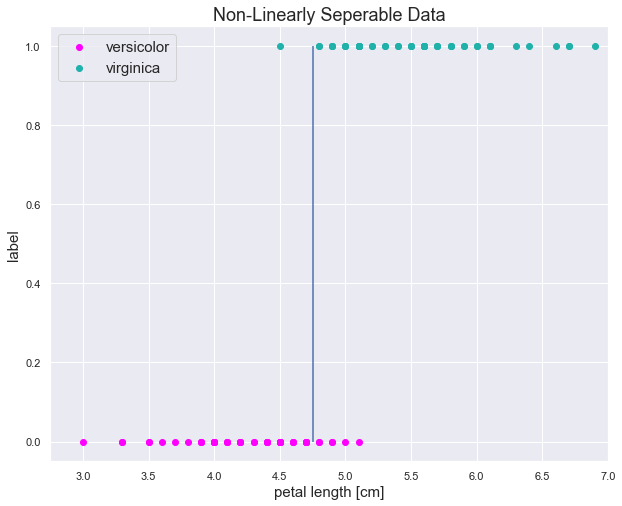

In [2]:
plt.figure(figsize = (10, 8))
plt.xlim((2.75, 7 ))
plt.scatter(versicolor.petal_length, 
            np.zeros(50), 
            color = "magenta", 
            label = "versicolor")
plt.scatter(virginica.petal_length, 
            np.ones(50), 
            color = "lightseagreen", 
            label = "virginica")
plt.vlines(4.75, 0.0, 1.0)
plt.xlabel("petal length [cm]", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("Non-Linearly Seperable Data", fontsize = 18)
plt.show()

---

## Designing a Single Neuron to Predict Probabilities
Instead of creating a single neuron model for predicting a class deterministic label, we will next build a single neuron model that predicts a *class probability*. First, recall the general single neuron model depicted in the following figure. 

The Single Neuron Model
---

<p align="center">
    <img src="general_single_neuron.png" width="500">
</p>

---

### The Sigmoid Activation Function

As before (both with the linear regression and Perceptron single neurons), we must first decide on an activation function before deciding on a cost/ loss function. For this purpose, we choose the *sigmoid* activation function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

This differentiable function has a range in $(0, 1)$, so it would seem suitable for a possible function to turn the pre-activation value into a value representing a probability. Moreover, the sigmoid function (sometimes called the *logistic function*) has a smooth "S"-shape that is perfect for probabilities values transitioning, either growing or shrinking, as the input feature changes. For example, run the following code in the cell below. 


---

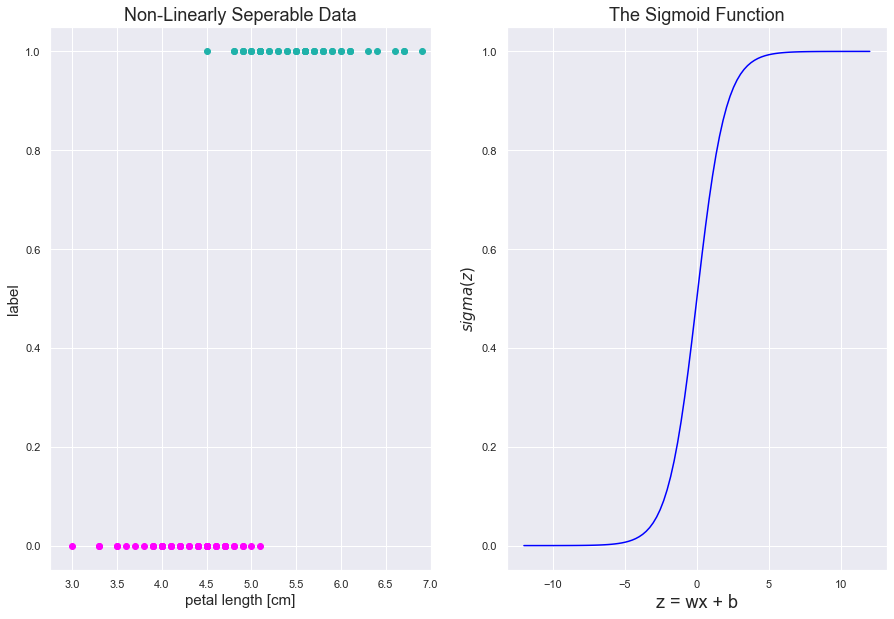

In [3]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.set_xlim((2.75, 7))
ax1.scatter(versicolor.petal_length, 
            np.zeros(50), 
            color = "magenta", 
            label = "versicolor")
ax1.scatter(virginica.petal_length, 
            np.ones(50), 
            color = "lightseagreen", 
            label = "virginica")
ax1.set_xlabel("petal length [cm]", fontsize = 15)
ax1.set_ylabel("label", fontsize = 15)
ax1.set_title("Non-Linearly Seperable Data", fontsize = 18)


domain = np.linspace(-12.0, 12.0, 100)
ax2.plot(domain, 
        sigmoid(domain), 
        color = "blue", 
        label = "$\sigma$(z)")
ax2.set_xlabel("z = wx + b", fontsize = 18)
ax2.set_ylabel("$sigma(z)$", fontsize = 15)
ax2.set_title("The Sigmoid Function", fontsize = 18)
plt.show()

---

As can be seen by the two figures generated above, the petal pre-activation value might be able to map the petal length measurements to the correct inputs to the sigmoid function so that the post-activation values correctly describe the probability of observing a versicolor flower or a virginica flower. In order to test this hypothesis, we must next introduce a cost/loss function to our single neuron model. 

## The Binary Cross Entropy Cost Function 
Currently we have two target values, 0 for versicolor and 1 for virginica. Moreover, we are wishing to predict that *probability of each of these labels given a single feature measurement*. Thus, we encounter the conditional probability function:

$$
P\Big(y^{(i)}\mid x^{(i)}\Big)=\begin{cases}
          \hat{y}^{(i)}, \quad &  y^{(i)} = 1 \\
          1-\hat{y}^{(i)}, \quad & y^{(i)} = 0 \\
     \end{cases}
$$

Notice that this conditional probability depends on the value of $\hat{y}^{(i)}$, which in-turn depends on the values of our weight and bias. Moreover, we wish to *maximize* this probability over all training examples since this quantity is largest when our predicted probabilities are close approximations to the true 0-1 labels. Thus, we seek to solve the following maximization problem:

$$
\max_{\mathbf{w}, b} \sum_{i=1}^{N}P\Big(y^{(i)}\mid x^{(i)}\Big).
$$

We need the cost function to be diferntiable, so replace it with the this: Before considering this optimization problem, we next recall the famous Bernoulli formula for binary probabilities:
$$
P\Big(y^{(i)}\mid x^{(i)}\Big) = [\hat{y}^{(i)}]^{y}[1 - \hat{y}^{(i)}]^{(1-y)}
$$

Taking the logorithm on both sides of this equation yields (dropping the index notation to avoid messy equations) become minimization problem:
$$
\begin{align} 
\log P\Big(y^{(i)}\mid x^{(i)}\Big)&= \log \hat{y}^{y}(1 - \hat{y})^{(1-y)}\\ 
&= y\log \hat{y} + (1-y) \log (1 - \hat{y})\\ 
\end{align}
$$

Since the logorithmic function is an *increasing function*, maximimizing $P\Big(y^{(i)}\mid x^{(i)}\Big)$ is equivalent to maximizing $\log P\Big(y^{(i)}\mid x^{(i)}\Big)$. Equivalently, we could also considering minimizing this negative of this function. Thus, we arrive at our single neuron coss/loss function for a single entry of data, which implies a full loss function. 

### Binary Cross Entropy Loss Function:
$$
L(\mathbf{w}, b) = -\frac{1}{N} \sum_{i=1}^{N} P\Big(y^{(i)}\mid x^{(i)}\Big) = \frac{1}{N}\sum_{i=1}^{N}\Big[ -y^{(i)}\log \hat{y}^{(i)} - (1-y^{(i)}) \log (1 - \hat{y}^{(i)})\Big ]
$$

Now that we have a plausible loss function, we have a complete single neuron model ready for training; see the figure below. 

The Logistic Regression Single Neuron Model
---

<p align="center">
    <img src="logistic_neuron.png" width="500">
</p>

---

## Calculuting the Gradient of Binary Cross Entropy Loss Function
In order to optimize the logistic regression single neuron model with stochastic gradient descent, we first need understand how to calculate the gradient. As before, we will consider the cost function on a single instance of data:

$$
C(w_1, b; x^{(i)},y^{(i)}) = -y^{(i)}\log \hat{y}^{(i)} - (1-y^{(i)}) \log (1 - \hat{y}^{(i)})
$$

When considering this equation it is important to remember that $\hat{y}^{(i)}$ really is a composite function. More specifically, we note

$$
\hat{y}^{(i)} = \sigma(z) = \sigma(w_1x^{(i)} + b).
$$

Next we note the particularly nice closed form of the derivative of the sigmoid function.

$$
\sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

With these two equations, we are now ready to compute the partial derivatives of $C(w_1, b; x_{1}^{(i)},y^{(i)})$ with respect to $w_1$ and $b$. Note that this cost function contains two pieces, namely $-y^{(i)}\log \hat{y}^{(i)}$ and $- (1-y^{(i)}) \log (1 - \hat{y}^{(i)})$. Since the derivative is a linear map, we may calculate $\partial C/ \partial w_1$ by calculating the the derivative of each piece of this equation and then add them together. 

$$
\begin{split}
\frac{\partial}{\partial w_1}[-y^{(i)}\log \hat{y}^{(i)}] & = \frac{\partial}{\partial w_1}[-y^{(i)}\log \sigma(w_1 x^{(i)}+b)] \\
 & = - \frac{y^{(i)}}{\sigma(w_1 x^{(i)}+b)}\frac{\partial}{\partial w_1} [\sigma(w_1 x^{(i)}+b)] \\
 & = - \frac{y^{(i)}}{\sigma(w_1 x^{(i)}+b)}\sigma(w_1 x^{(i)}+b)(1 - \sigma(w_1 x^{(i)}+b))\frac{\partial}{\partial w_1}[w_1 x^{(i)}+b] \\
 & = - y^{(i)}(1 - \sigma(w_1 x^{(i)}+b))x^{(i)} \\
 & = - y^{(i)}(1 - \hat{y}^{(i)})x^{(i)} 
\end{split}
$$

$$
\begin{split}
\frac{\partial}{\partial w_1}[-(1-y^{(i)}) \log (1 - \hat{y}^{(i)})] & = \frac{\partial}{\partial w_1}[-(1-y^{(i)})\log (1 - \sigma(w_1 x^{(i)}+b))] \\
 & = - \frac{(1 - y^{(i)})}{(1 - \sigma(w_1 x^{(i)}+b))}\frac{\partial}{\partial w_1} [1 - \sigma(w_1 x^{(i)}+b) ]\\
 & = -  \frac{(1 - y^{(i)})}{(1 - \sigma(w_1 x^{(i)}+b))} -\sigma(w_1 x^{(i)}+b)(1 - \sigma(w_1 x^{(i)}+b))\frac{\partial}{\partial w_1}[w_1 x^{(i)}+b] \\
 & = (1 - y^{(i)})\sigma(w_1 x^{(i)}+b))x^{(i)} \\
 & = (1 - y^{(i)})\hat{y}^{(i)}x^{(i)} 
\end{split}
$$

Now that we have calculated the derivative with respect to $w_1$ for each part of the binary cross entropy loss function, we next sum these derivatives:

$$
\begin{split}
\frac{\partial C(w_1, b; x^{(i)},y^{(i)})}{\partial w_1} & = - y^{(i)}(1 - \hat{y}^{(i)})x^{(i)} + (1 - y^{(i)})\hat{y}^{(i)}x^{(i)} \\
 & = [- y^{(i)}(1 - \hat{y}^{(i)}) + (1 - y^{(i)})\hat{y}^{(i)}]x^{(i)} \\
 & = [- y^{(i)} + y^{(i)}\hat{y}^{(i)} + \hat{y}^{(i)} - y^{(i)}\hat{y}^{(i)}]x^{(i)} \\
 & = (\hat{y}^{(i)} - y^{(i)}) x^{(i)}
\end{split}
$$

A similar calculation also yields the partial derivative of our cost function with respect to the bias $b$:

$$
\frac{\partial C(w_1, b; x^{(i)},y^{(i)})}{\partial b} = (\hat{y}^{(i)} - y^{(i)})
$$

Notice how these partial derivatives precisely match the partial derivatives of the linear regression single neuron and the approximate partial derivatives of the Perceptron single neuron! Thus, we can train our logistic regression neuron in the exact same way as our previous models by implementing stochastic gradient descent. We now define our custom single neuron class for this purpose. 
ach feature vector. 
 


---

In [4]:
class SingleNeuron(object):
    """
    A class used to represent a single artificial neuron. 

    ...

    Attributes
    ----------
    activation_function : function
        The activation function applied to the preactivation linear combination.
    
    cost_function : function
        The cost function used to measure model performance.

    w_ : numpy.ndarray
        The weights and bias of the single neuron. The last entry being the bias. 
        This attribute is created when the train method is called.

    errors_: list
        A list containing the mean sqaured error computed after each iteration 
        of stochastic gradient descent per epoch. 

    Methods
    -------
    train(self, X, y, alpha = 0.005, epochs = 50)
        Iterates the stochastic gradient descent algorithm through each sample 
        a total of epochs number of times with learning rate alpha. The data 
        used consists of feature vectors X and associated labels y. 

    predict(self, X)
        Uses the weights and bias, the feature vectors in X, and the 
        activation_function to make a y_hat prediction on each feature vector. 
    """
    def __init__(self, activation_function: callable, cost_function: callable):
        self.activation_function = activation_function
        self.cost_function = cost_function

    def train(self, X, y, alpha = 0.005, epochs = 50):
   
        self.w_ = np.random.randn(1 + X.shape[1])
        
        N = X.shape[0]

        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                self.w_[:-1] -= alpha*error*xi
                self.w_[-1] -= alpha*error
                #errors += .5*((self.predict(xi) - target)**2)
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors/N)
        return self

    def predict(self, X):
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), 
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

---

Now that we have defined a custom ```SingleNeuron``` class we are one step closer to training our model on the data at hand. However, before instantiating an instance of the ```SingleNeuron``` class we must first write a function for the binary cross entropy loss. Afterwards we may then create an instantance of our ```SingleNeuron```. Once this is done we need to convert the versicolor and virginica petal length measurements to a ```numpy.ndarray``` and reshape it into a column vector representation (**recall that this is necessary whenever our feature measurements consist of a single measurement**). We then need to create a target $y$ ```numpy.ndarray``` which assigns the labels 0 and 1 to the versicolor and virginica species, respectively. 

Once we have our feature vector and target vector we can then pass these values into the ```SingleNeuron.train()``` method to train our logistic single neuron with stochastic gradient descent. All of this can be done by running the following code in the cell below.


---

In [5]:
def cross_entropy_loss(y_hat, y):
    return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

node = SingleNeuron(sigmoid, cross_entropy_loss)

X = df.iloc[50:].petal_length.values
X = X.reshape(-1, 1) #rearrage it into a vector 
y = np.where(df.iloc[50:].species == "versicolor", 0, 1)

node.train(X, y, alpha = 0.01, epochs = 10_000)

---

Now that we have trained the variable ```node```, we can now visualize the binary cross entropy loss over each epoch by plotting the values in the ```SingleNeuron.errors_``` attribute. This can be done by running the following code in the cell below. 


---

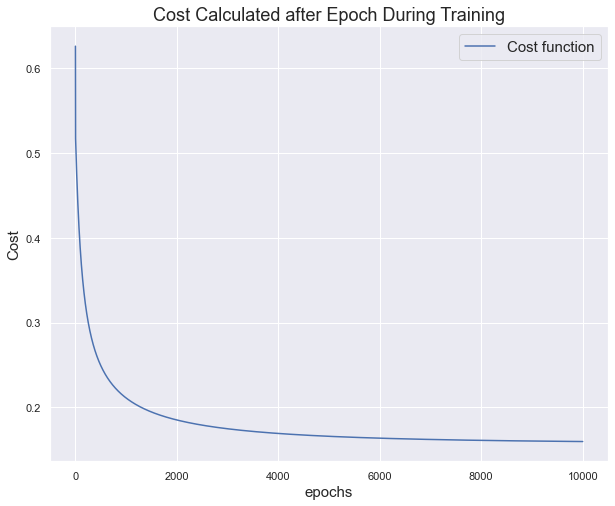

In [6]:
node.plot_cost_function()
plt.show()

---

This looks good! Visualizing the cost function over the epochs during training helps us verify that are neuron is indeed learning over time. We can next visualize our hypthesis function, or prediction function (recall in all supervised machine learning we are learning a function $h$ which approximates the true target function $f$), by plotting the ```SingleNeuron.predict()``` method over the scattered data points in question. This can be done by running the following code in the cell below.


---

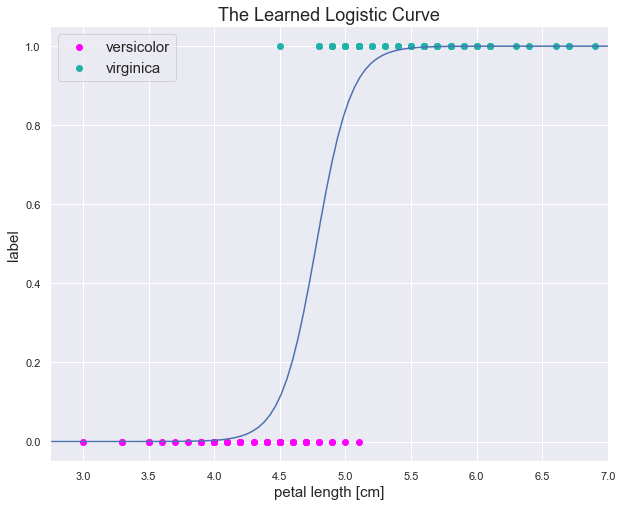

In [7]:
plt.figure(figsize = (10, 8))
plt.xlim((2.75, 7 ))
plt.scatter(versicolor.petal_length, 
            np.zeros(50), 
            color = "magenta", 
            label = "versicolor")
plt.scatter(virginica.petal_length, 
            np.ones(50), 
            color = "lightseagreen", 
            label = "virginica")

domain = np.linspace(2.75, 7, 100) 
plt.plot(domain, node.predict(domain.reshape(-1, 1)))
plt.xlabel("petal length [cm]", fontsize = 15)
plt.ylabel("label", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.title("The Learned Logistic Curve", fontsize = 18)
plt.show()
# notice the line has been shifted to match to the data

In [8]:
node.predict(X)
# each of these corresponde to the flower to pass it, take the nearest integer to make the predict

array([3.57735664e-01, 1.11783464e-01, 7.11409748e-01, 3.04480889e-03,
       2.09336615e-01, 1.11783464e-01, 3.57735664e-01, 1.67460775e-05,
       2.09336615e-01, 1.44963782e-03, 7.41101863e-05, 1.33365399e-02,
       3.04480889e-03, 3.57735664e-01, 1.55896815e-04, 5.64456855e-02,
       1.11783464e-01, 6.38407244e-03, 1.11783464e-01, 1.44963782e-03,
       5.39546610e-01, 3.04480889e-03, 7.11409748e-01, 3.57735664e-01,
       2.76497813e-02, 5.64456855e-02, 5.39546610e-01, 8.38344807e-01,
       1.11783464e-01, 7.41101863e-05, 6.89596559e-04, 3.27912054e-04,
       1.44963782e-03, 9.16037498e-01, 1.11783464e-01, 1.11783464e-01,
       3.57735664e-01, 5.64456855e-02, 6.38407244e-03, 3.04480889e-03,
       5.64456855e-02, 2.09336615e-01, 3.04480889e-03, 1.67460775e-05,
       1.33365399e-02, 1.33365399e-02, 1.33365399e-02, 2.76497813e-02,
       1.79860171e-06, 6.38407244e-03, 9.99886455e-01, 9.16037498e-01,
       9.99761159e-01, 9.97780614e-01, 9.99497669e-01, 9.99998690e-01,
      

---

When using the trained weights and bias of our logistic single neuron to predict a class on a given measurement, we will need to convert the predicted probabilities to zeros and ones. This can be done by passing the ```numpy.ndarray``` returned by the ```SingleNeuron.predict()``` method into the ```numpy.rint()``` method. Moreover, we can use the resulting ```numpy.ndarray``` to compute the classification error over our training data given by the formula

$$
E_c = \frac{1}{N}\sum_{i=1}^{N}[\hat{y}^{(i)} \neq y^{(i)}],
$$

where $[\hat{y}^{(i)} \neq y^{(i)}] = 1$ whenever $\hat{y}^{(i)} \neq y^{(i)}$, and zero otherwise. Run the following code in the cell below to view this classification error. 


---

In [11]:
np.rint(node.predict(X)) != y

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [12]:
classification_error = (np.rint(node.predict(X)) != y).astype(int) 
print(f"Classification Error = {sum(classification_error)/ len(y)}")

Classification Error = 0.07


---

This is a great classification error on our training data! We can now view our decision boundary implied by the trained weights and bias by running the following code in the cell below.



---

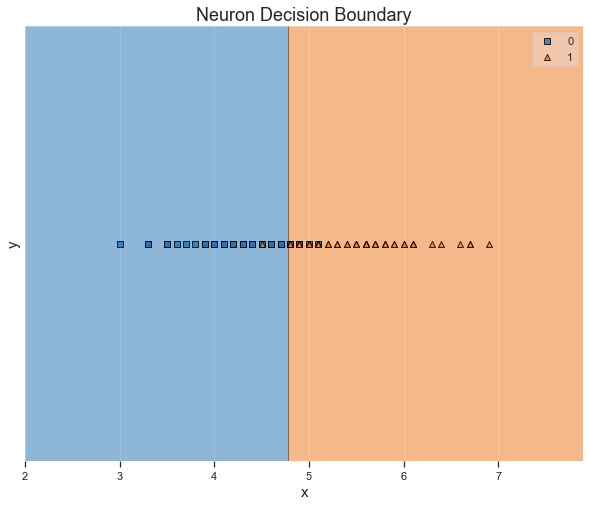

In [13]:
node.plot_decision_boundary(X, y)
plt.show()

---

## Logistic Regression Single Neuron with Multiple Inputs
Thus far we have only used a single feature measurement as input into our logistic regression single neuron model, but what happens when we use *multiple measurements*. For example, we could use petal length and petal width. With two inputs our model can be depicted by the figure below.

The Logistic Single Neuron Model with Multiple Feature Inputs
---

<p align="center">
    <img src="multi_logistic_neuron.png" width="500">
</p>

---

Let us next instantiate a ```SingleNeuron``` model with petal length and sepal length measurements as input, train this model with the same learning rate and number of epochs as the variable ```node```, and then compare the cost function over epochs between the two models. This can be done by running the following code in the cell below. 


---

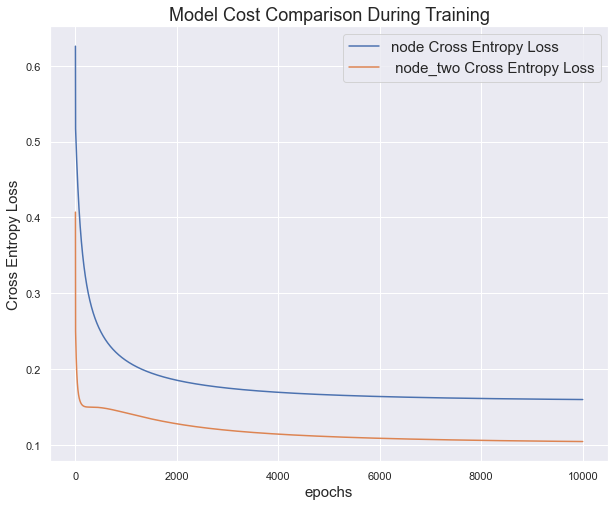

In [14]:
# Instantiate a new single neuron.
node_two = SingleNeuron(sigmoid, cross_entropy_loss)

# Create a numpy.ndarray of petal length and sepal length values for
# the versicolor and virginica flowers, respectively. 
X_two = df.iloc[50:][["petal_length", "sepal_length"]].values

# Train the new single neuron model on the new feature vectors.
node_two.train(X_two, y, alpha = 0.01, epochs = 10_000)


plt.figure(figsize = (10, 8))
plt.plot(range(1, len(node.errors_) + 1), 
         node.errors_,
         label = "node Cross Entropy Loss")
plt.plot(range(1, len(node_two.errors_) + 1), 
         node_two.errors_,
         label = " node_two Cross Entropy Loss")
plt.xlabel("epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)


plt.show()

---

As we can see by the figures generated above, using two features results in a lower cost function (in this particular instance) with the same learning rate and number of epochs. We encourage the reader to compare different combinations of features from the data and compare the loss function over time during training. Finally, let us visualize the decision boundary generated by the trained weights and bias of ```node_two``` by running the following code in the cell below. After running notice that even with the logistic regression single neuron, we are still learning a linearly seperating hyperplane.  


---

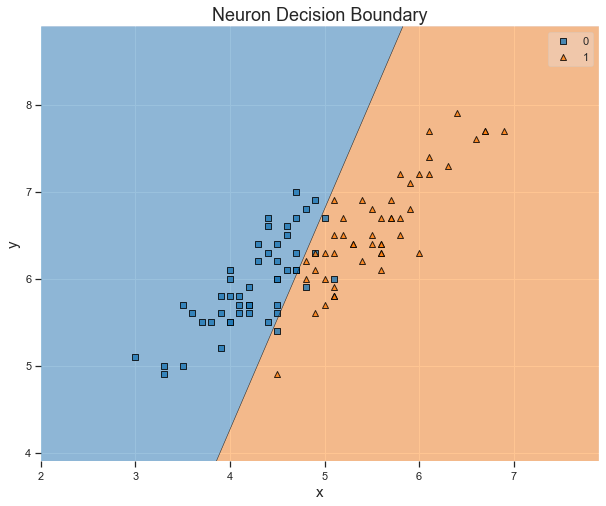

In [15]:
node_two.plot_decision_boundary(X_two, y)

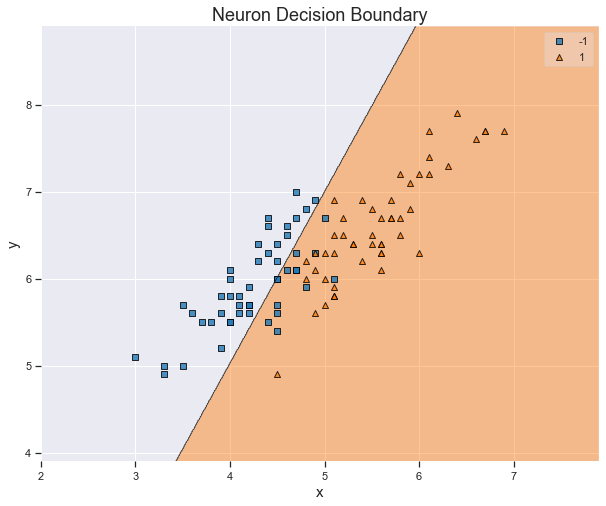

In [16]:
def sign(z):
    return np.sign(z)

def MSE(y_hat, y):
    return .5*(y_hat - y)**2

# Instantiate a new single neuron.
node_three = SingleNeuron(sign, MSE)

# Create a numpy.ndarray of petal length and sepal length values for
# the versicolor and virginica flowers, respectively. 
X_three = df.iloc[50:][["petal_length", "sepal_length"]].values

y_three = np.where(df.iloc[50:]["species"] == "versicolor", -1, 1)


# Train the new single neuron model on the new feature vectors.
node_three.train(X_three, y_three, alpha = 0.001, epochs = 5_000)

node_three.plot_decision_boundary(X_three, y_three)
plt.show()

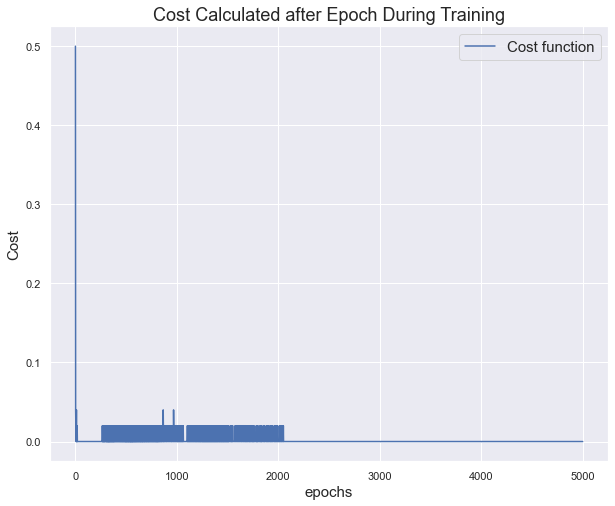

In [17]:
node_three.plot_cost_function()

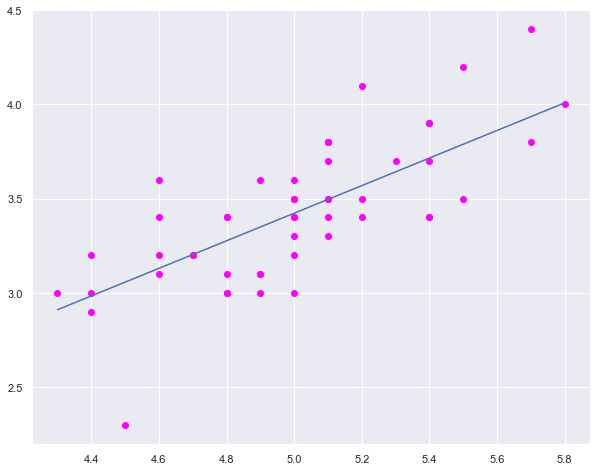

In [18]:
def linear(z):
    return z

# Instantiate a new single neuron.
node_four = SingleNeuron(linear, MSE)

# Create a numpy.ndarray of petal length and sepal length values for
# the versicolor and virginica flowers, respectively. 
X_four = df.iloc[0:50]["sepal_length"].values
X_four = X_four.reshape(-1, 1)

y_four = df.iloc[0:50]["sepal_width"].values


# Train the new single neuron model on the new feature vectors.
node_four.train(X_four, y_four, alpha = 0.001, epochs = 5_000)

plt.figure(figsize = (10, 8))
plt.scatter(X_four, y_four, label = "setosa", color = "magenta")

domain = np.linspace(np.min(X_four), np.max(X_four), 50)
plt.plot(domain, node_four.predict(domain.reshape(-1, 1)), label = "regression line")
plt.show()